# Data Loading and Initial Inspection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('kc_final.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (21613, 22)

First few rows:
   Unnamed: 0          id        date     price  bedrooms  bathrooms  \
0           0  7129300520  2014-10-13  221900.0         3       1.00   
1           1  6414100192  2014-12-09  538000.0         3       2.25   
2           2  5631500400  2015-02-25  180000.0         2       1.00   
3           3  2487200875  2014-12-09  604000.0         4       3.00   
4           4  1954400510  2015-02-18  510000.0         3       2.00   

   sqft_living  sqft_lot  floors  waterfront  ...  grade  sqft_above  \
0         1180      5650     1.0           0  ...      7        1180   
1         2570      7242     2.0           0  ...      7        2170   
2          770     10000     1.0           0  ...      6         770   
3         1960      5000     1.0           0  ...      7        1050   
4         1680      8080     1.0           0  ...      8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0   

# Data Cleaning and Preprocessing

Missing values:
 Unnamed: 0       0
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
Number of duplicates: 0


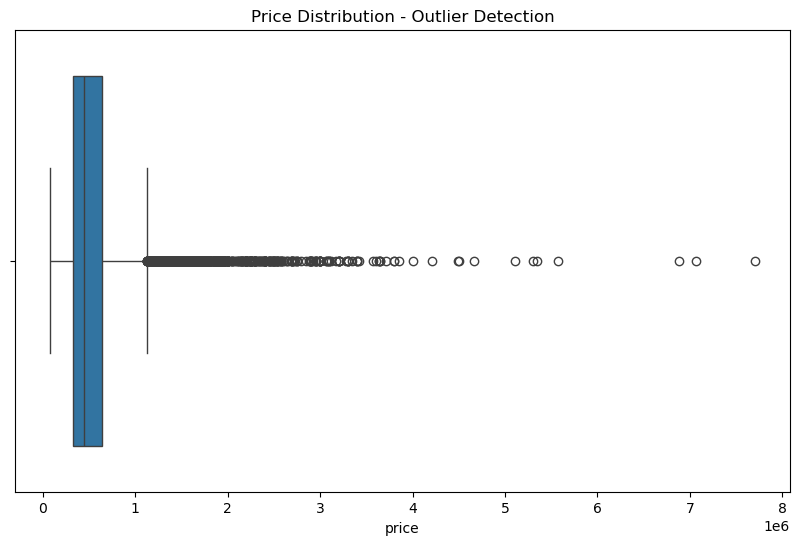

Dataset shape after cleaning: (21381, 22)


In [3]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop the unnecessary index column
df = df.drop(columns=['Unnamed: 0'])

# Convert date to datetime and extract useful features
df['date'] = pd.to_datetime(df['date'])
df['year_sold'] = df['date'].dt.year
df['month_sold'] = df['date'].dt.month
df = df.drop(columns=['date'])

# Check for duplicates
print("Number of duplicates:", df.duplicated().sum())

# Handle zero values in important columns
# For sqft_living, bedrooms, bathrooms - zero doesn't make sense
df = df[df['sqft_living'] > 0]
df = df[df['bedrooms'] > 0]
df = df[df['bathrooms'] > 0]

# Check for outliers in price
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Price Distribution - Outlier Detection')
plt.show()

# Remove extreme outliers (top 1%)
price_q99 = df['price'].quantile(0.99)
df = df[df['price'] <= price_q99]

print("Dataset shape after cleaning:", df.shape)

# Exploratory Data Analysis (EDA)

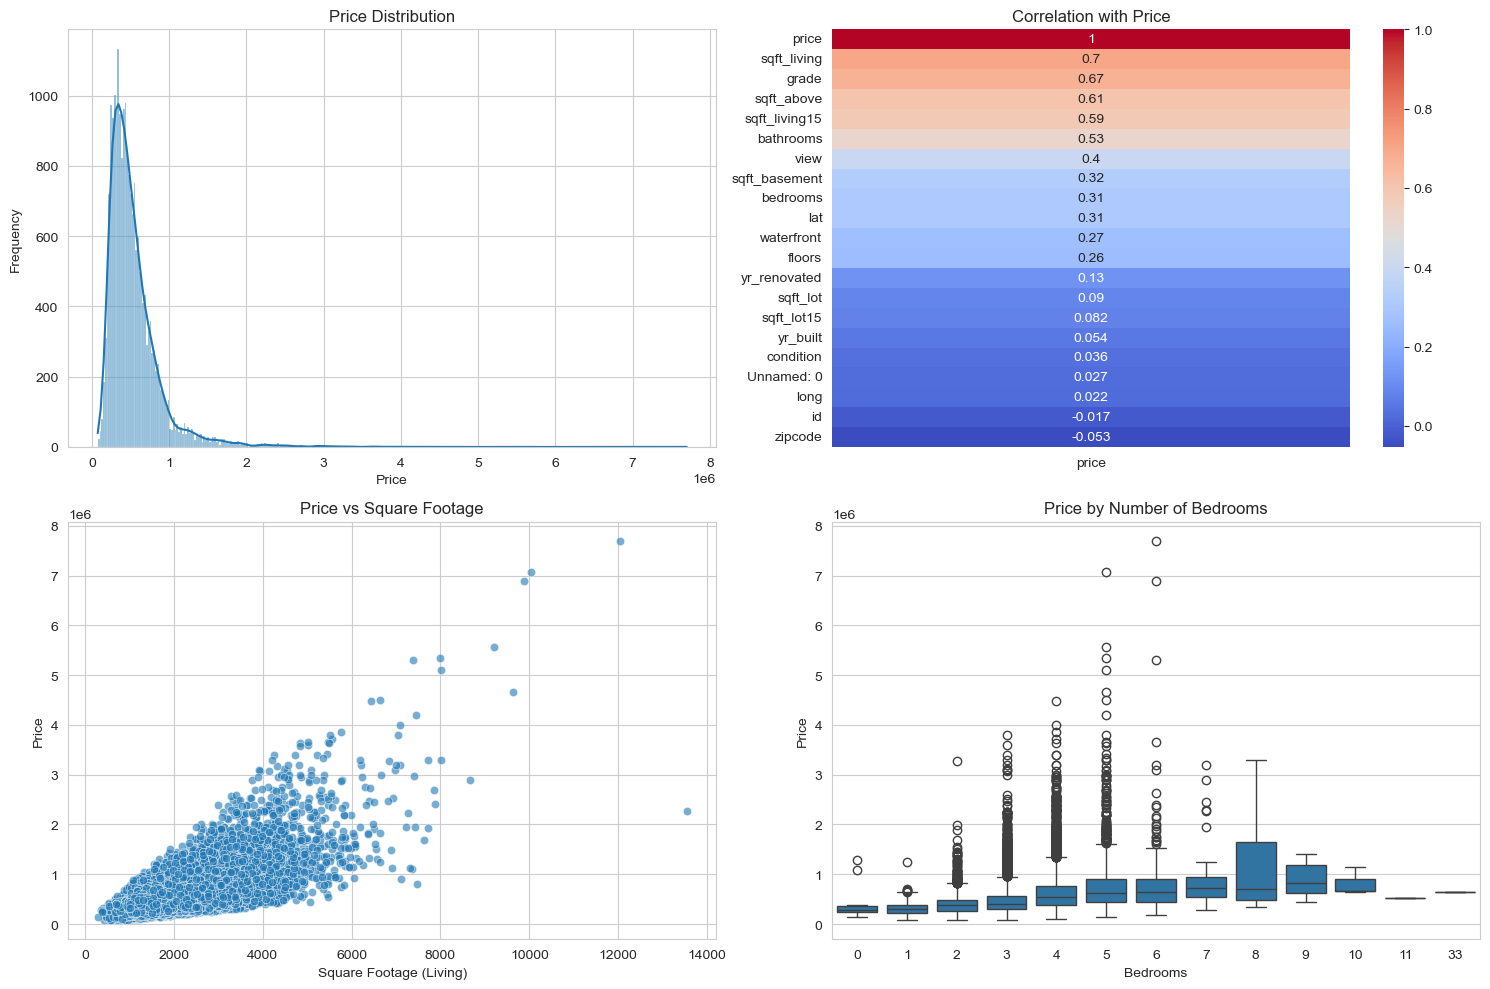

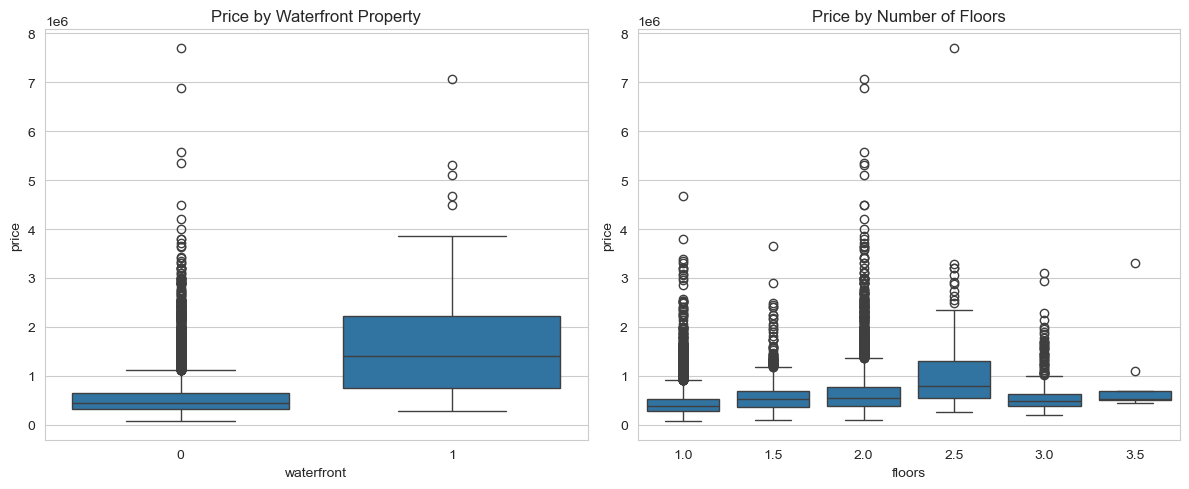

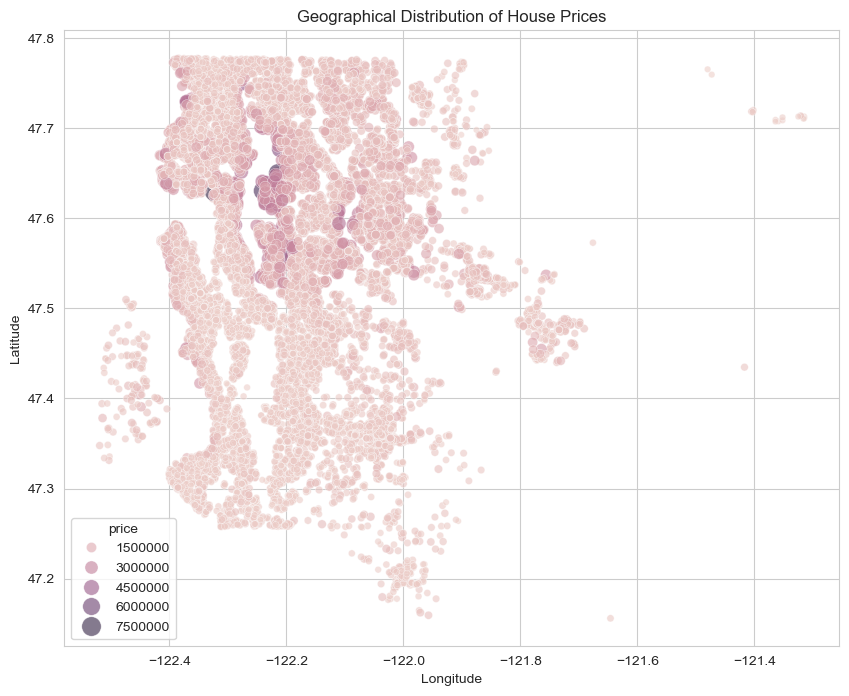

In [6]:
# Set up the visualization style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# 1. Price distribution
plt.subplot(2, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# 2. Correlation heatmap
plt.subplot(2, 2, 2)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix[['price']].sort_values(by='price', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlation with Price')

# 3. Price vs Square Footage
plt.subplot(2, 2, 3)
sns.scatterplot(x='sqft_living', y='price', data=df, alpha=0.6)
plt.title('Price vs Square Footage')
plt.xlabel('Square Footage (Living)')
plt.ylabel('Price')

# 4. Price by Number of Bedrooms
plt.subplot(2, 2, 4)
sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('Price by Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

# Additional EDA
# Price by waterfront property
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='waterfront', y='price', data=df)
plt.title('Price by Waterfront Property')

# Price by number of floors
plt.subplot(1, 2, 2)
sns.boxplot(x='floors', y='price', data=df)
plt.title('Price by Number of Floors')

plt.tight_layout()
plt.show()

# Geographical analysis
plt.figure(figsize=(10, 8))
sns.scatterplot(x='long', y='lat', hue='price', size='price', 
                sizes=(20, 200), alpha=0.6, data=df)
plt.title('Geographical Distribution of House Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Feature Engineering

In [7]:
# Create new features that might be predictive
df['age'] = df['year_sold'] - df['yr_built']
df['renovated'] = np.where(df['yr_renovated'] > 0, 1, 0)
df['renovation_age'] = np.where(df['yr_renovated'] > 0, 
                               df['year_sold'] - df['yr_renovated'], 0)

# Create a feature for total rooms
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

# Create a feature for price per square foot
df['price_per_sqft'] = df['price'] / df['sqft_living']

# Create a feature for lot size to living space ratio
df['lot_to_living_ratio'] = df['sqft_lot'] / df['sqft_living']

# Check the new features
print(df[['age', 'renovated', 'renovation_age', 'total_rooms', 
          'price_per_sqft', 'lot_to_living_ratio']].head())

   age  renovated  renovation_age  total_rooms  price_per_sqft  \
0   59          0               0         4.00      188.050847   
1   63          1              23         5.25      209.338521   
2   82          0               0         3.00      233.766234   
3   49          0               0         7.00      308.163265   
4   28          0               0         5.00      303.571429   

   lot_to_living_ratio  
0             4.788136  
1             2.817899  
2            12.987013  
3             2.551020  
4             4.809524  


# Data Preparation for Modeling

In [9]:
# Select features for modeling
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
            'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 
            'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 
            'renovated', 'renovation_age', 'total_rooms', 
            'lot_to_living_ratio']

X = df[features]
y = df['price']

# Handle categorical variables (zipcode)
X = pd.get_dummies(X, columns=['zipcode'], drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (17104, 91)
Test set shape: (4277, 91)


# Model Building and Evaluation

In [13]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'R2 Score': r2
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R2 Score: {r2:.4f}")
    print()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)

NameError: name 'X_train_scaled' is not defined